### **Project work for the course Artificial Intelligence in Industry at University of Bologna - Master's degree in Artificial Intelligence**

#### Stefano Poggi Cavalletti - 0000982439

### **Classification of ECG signals**

The aim of this project is to perform a classification task on health data related to ECG signals, which are recordings of the heart's electrical activity. To perform this task, we will use an available dataset which contains ECG data of real patients: ECG5000. 

The [ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) dataset is available in the UCR Time Series Classification archive and contains a set of 5000 univariate time series with 140 timesteps (T = 140). Each sequence corresponds to a single heartbeat from a single patient. Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. The frequency is 60-100 per minute and the duration is 0.6–1 second.

Five classes are annotated, corresponding to the following labels: 

*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T 
PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Import the dataset files

ecg_train_file = 'ECG5000_TRAIN.csv'
ecg_test_file = 'ECG5000_TEST.csv'

train_data = pd.read_csv(ecg_train_file)
test_data = pd.read_csv(ecg_test_file)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

In [3]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [22]:
# 140 timesteps + target
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns

In [23]:
df['target'] = df[df.columns[-1]]
del df[df.columns[-1]]

In [8]:
df

,target,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140
0,1,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,...,0.205543,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334
4996,2,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,...,1.218185,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932
4997,2,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,...,-0.896575,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531
4998,2,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,...,-2.495989,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568


In [9]:
df.describe()

,target,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.527400,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,...,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,0.760372,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,...,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,...,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227
25%,1.000000,-1.004511,-2.701576,-3.668096,-4.227247,-4.007470,-3.480479,-2.779941,-2.165851,-1.774124,...,-0.655753,-1.089300,-1.588885,-2.147449,-2.731550,-3.030509,-2.868331,-2.153513,-1.657771,-1.596692
50%,1.000000,-0.297541,-1.661892,-2.585677,-3.387934,-3.468718,-2.947061,-2.285578,-1.750157,-1.422570,...,0.473642,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.565588
75%,2.000000,0.500061,-0.677290,-1.513964,-2.235369,-2.530967,-2.398813,-1.823494,-1.484923,-1.063708,...,1.062134,1.169420,1.238687,1.264471,1.234433,1.034584,0.945237,0.951681,1.002692,0.272012
max,5.000000,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,...,2.960969,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103


What we can see is that the min and max values are between the range [-7,7], the mean value is more or less in range between [-1,1].

In [10]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [11]:
normal_class = 1
class_names = ['Normal','R on T','PVC','SP','UB']

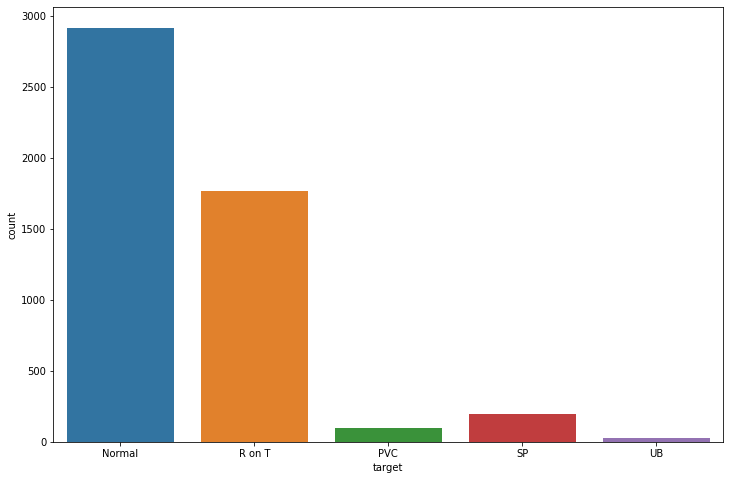

In [12]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

In [13]:
df_train = df[:4500]
df_test = df[4500:5000]

### SMOTE for handling inbalanced datasets

SMOTE = Synthetic Minority Oversampling TEchnique

In [16]:
from imblearn.combine import SMOTETomek
def over_under_sampling(dataframe):
    """
    Use SMOTETomek technique to oversample our dataset. 
    
    This function is written to be applied to our datasets, 
    where the first column holds the labels, and the rest is the 
    time sequence. 

    It passes the under-represented data - classes 2-5 along
    with the dominant class 1 into the SMOTETomek over- & undersampler
    to balance the dataset. 
    """
    # lists to store the created values in
    x_res = []
    y_res = []

    for i in range(2,6):

        # create copy of the dataframe
        df_copy = dataframe.copy()
        # choose samples of i-th class
        df = df_copy[df_copy['target'] == i]
        # add samples from 1st class
        df = df.append(df_copy[df_copy['target'] == 1])
        # split the dataframe into x - data and y - labels
        x = df.values[:,1:]
        y = df.values[:,0]

        # define the imbalance function
        smtomek = SMOTETomek(random_state=42)
        # fit it on our data
        x_r, y_r = smtomek.fit_resample(x, y)
        
        # we want to skip the data we fit it on - only want the new data
        skip = y.shape[0]
        # append the data into our above lists
        x_res.append(x_r[skip:,:])
        y_res.append(y_r[skip:])

    # return the data as concatenated arrays -> only one array of all samples
    # instead of a list of arrays
    return np.concatenate(x_res), np.concatenate(y_res)

In [26]:
X_os, y_os = over_under_sampling(df_train)

### Split the dataframe into data-points and labels

In [18]:
X_train = df_train.values[:,1:]  # [all rows, column 1 to end]
y_train = df_train.values[:,0]   # [all rows, column 0]

X_test = df_test.values[:,1:]    # [all rows, column 1 to end]
y_test = df_test.values[:,0]     # [all rows, column 0]

In [27]:
X_train = np.concatenate((X_train, X_os))
y_train = np.concatenate((y_train, y_os))

<BarContainer object of 5 artists>

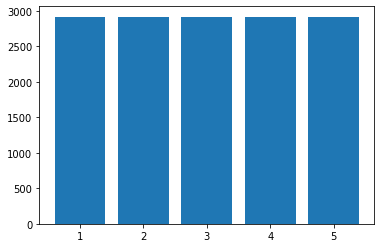

In [21]:
lbl, count = np.unique(y_train, return_counts=True)

plt.bar(lbl, count)

### Visualizing the signals

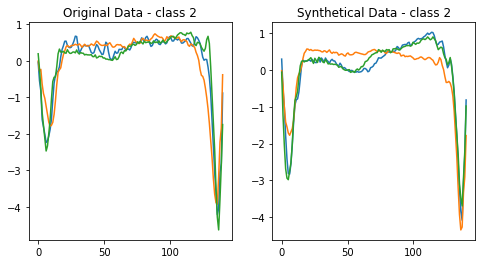

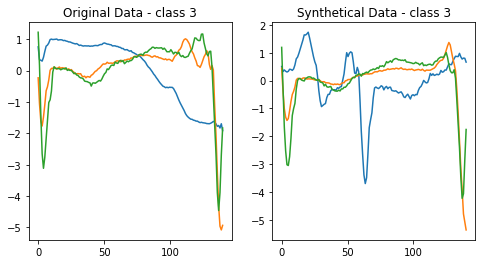

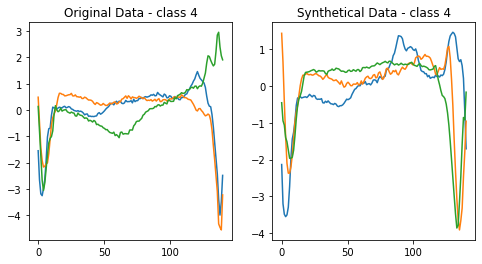

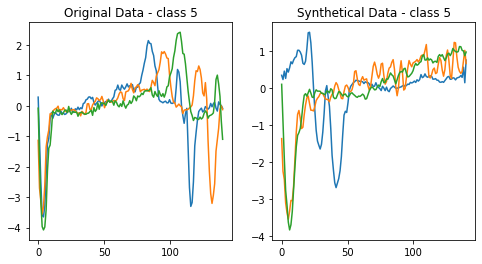

In [28]:
t = np.linspace(0,140, 140)

for i in range(2,6):
    id = np.where(y_train == i)[0][:3]
    id_os = np.where(y_os == i)[0][:3]


    plt.figure(figsize=(8,4))
    plt.subplot(1,2 , 1) 
    plt.plot(t, X_train[id[0]], t, X_train[id[1]], t, X_train[id[2]], )
    plt.title('Original Data - class ' + str(i))
    
    plt.subplot(1, 2, 2) 
    plt.plot(t, X_os[id_os[0]], t, X_os[id_os[1]], t, X_os[id_os[2]], )
    plt.title('Synthetical Data - class ' + str(i))

In [29]:
scaler = preprocessing.MinMaxScaler()
data_scaler = scaler.fit(X_train)

In [30]:
X_train = data_scaler.transform(X_train)
X_test = data_scaler.transform(X_test)

In [31]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [32]:
# we need to index classes from 0 to 4
y_train = y_train - 1            
y_test = y_test - 1

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42) 

In [40]:
# Functions to plot accuracy, loss and confusion matrix

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    return plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    return plt.show()

def cm_plot(model, x_test):
    y_predict = model.predict(x_test)
    y_pred = []

    for i in range(len(y_predict)):
        y_pred.append(np.argmax(y_predict[i,:]))

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix")

    return plt.show()

### Model 1: Conv1D

About the input shape, we have data with 140 timesteps and only one feature (array 140x1). However, if you happen to have data which have more features - I/Q representation with (tx2) shape where t are the timesteps you can simply change the 1 to match the number of your feature representations.

In [35]:
layer_in = layers.Input(shape=(140,1))
layer = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(layer_in)
layer = layers.MaxPool1D(pool_size=2)(layer)
layer = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(layer)
layer = layers.MaxPool1D(pool_size=2)(layer)
layer = layers.Flatten()(layer)
layer = layers.Dense(32, activation='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer_out = layers.Dense(5, activation='softmax')(layer)

model = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
             keras.callbacks.ModelCheckpoint('model.h5', 
                                             save_best_only=True, 
                                             monitor='val_loss'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.1, 
                                               patience=3,
                                               ),
             keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=8,
                                           verbose=1)
             ]

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 137, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 68, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 32)            4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0     

In [37]:
history = model.fit(X_train, y_train,
                    batch_size=128, epochs=50, verbose=2,
                    validation_data=(X_val, y_val),
                    shuffle=True, callbacks=callbacks)

Epoch 1/50
155/155 - 5s - loss: 1.3406 - accuracy: 0.3819 - val_loss: 0.9850 - val_accuracy: 0.6164 - lr: 0.0010 - 5s/epoch - 30ms/step
Epoch 2/50
155/155 - 4s - loss: 0.9300 - accuracy: 0.5963 - val_loss: 0.7370 - val_accuracy: 0.7094 - lr: 0.0010 - 4s/epoch - 23ms/step
Epoch 3/50
155/155 - 4s - loss: 0.7488 - accuracy: 0.6696 - val_loss: 0.5806 - val_accuracy: 0.7730 - lr: 0.0010 - 4s/epoch - 23ms/step
Epoch 4/50
155/155 - 4s - loss: 0.6311 - accuracy: 0.7245 - val_loss: 0.5035 - val_accuracy: 0.7922 - lr: 0.0010 - 4s/epoch - 23ms/step
Epoch 5/50
155/155 - 4s - loss: 0.5682 - accuracy: 0.7510 - val_loss: 0.4487 - val_accuracy: 0.8137 - lr: 0.0010 - 4s/epoch - 23ms/step
Epoch 6/50
155/155 - 4s - loss: 0.5144 - accuracy: 0.7673 - val_loss: 0.4188 - val_accuracy: 0.8121 - lr: 0.0010 - 4s/epoch - 23ms/step
Epoch 7/50
155/155 - 4s - loss: 0.4800 - accuracy: 0.7804 - val_loss: 0.3849 - val_accuracy: 0.8267 - lr: 0.0010 - 4s/epoch - 23ms/step
Epoch 8/50
155/155 - 4s - loss: 0.4558 - accurac

16/16 [==============================] - 0s 4ms/step - loss: 0.8987 - accuracy: 0.8400
Test accuracy 0.8399999737739563
Test loss 0.8986784815788269


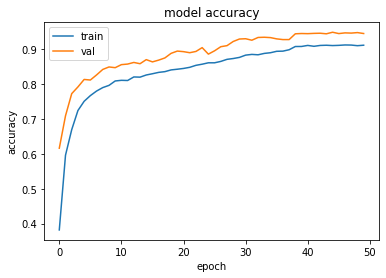

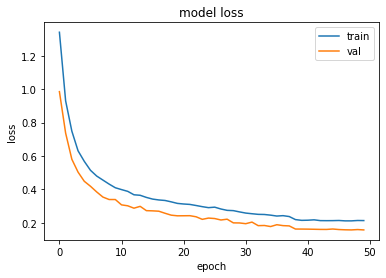

16/16 [==============================] - 0s 4ms/step


<ipython-input-40-17cb580e5144>:30: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


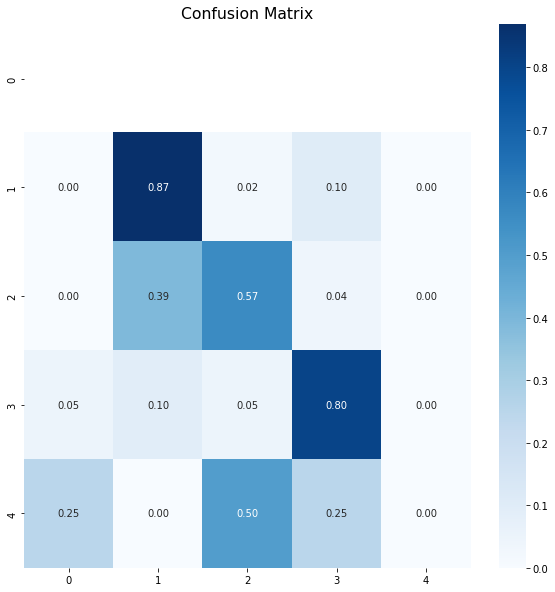

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

plot_acc(history)
plot_loss(history)
cm_plot(model, X_test)

### Model 2: LSTM

We have data with 140 timesteps and only one feature (array 140x1). However, if you happen to have data which have more features - I/Q representation with (tx2) shape where t are the timesteps you can simply change the 1 to match the number of your feature representations.

However unlike when using conv1d only, you could set the timesteps value to None. This allows you to train and test your data on a variable sequence length.

The only thing you have to do when training the model is to have batches of the same size.

In [42]:
layer_in = layers.Input(shape=(140,1)) 
layer = layers.LSTM(16, return_sequences=True)(layer_in)
layer = layers.Dropout(0.4)(layer)
layer = layers.GRU(16, return_sequences=False)(layer)
layer = layers.Dropout(0.4)(layer)
layer = layers.Dense(32, activation='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer_out = layers.Dense(5, activation='softmax')(layer)

model1 = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
             keras.callbacks.ModelCheckpoint('model.h5', 
                                             save_best_only=True, 
                                             monitor='val_loss'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.1, 
                                               patience=3,
                                               ),
             keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=8,
                                           verbose=1)
             ]

model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [43]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 140, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 140, 16)           1152      
                                                                 
 dropout_1 (Dropout)         (None, 140, 16)           0         
                                                                 
 gru (GRU)                   (None, 16)                1632      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0   

In [44]:
history1 = model1.fit(X_train, y_train,
                      batch_size=128, epochs=50, verbose=2,
                      validation_data=(X_val, y_val),
                      shuffle=True, callbacks=callbacks)

Epoch 1/50
155/155 - 31s - loss: 1.4509 - accuracy: 0.3321 - val_loss: 1.1530 - val_accuracy: 0.5324 - lr: 0.0010 - 31s/epoch - 201ms/step
Epoch 2/50
155/155 - 21s - loss: 1.1475 - accuracy: 0.5053 - val_loss: 0.9822 - val_accuracy: 0.5899 - lr: 0.0010 - 21s/epoch - 135ms/step
Epoch 3/50
155/155 - 22s - loss: 1.0538 - accuracy: 0.5494 - val_loss: 0.9097 - val_accuracy: 0.6191 - lr: 0.0010 - 22s/epoch - 140ms/step
Epoch 4/50
155/155 - 19s - loss: 1.0034 - accuracy: 0.5697 - val_loss: 0.8620 - val_accuracy: 0.6227 - lr: 0.0010 - 19s/epoch - 123ms/step
Epoch 5/50
155/155 - 18s - loss: 0.9426 - accuracy: 0.5963 - val_loss: 0.8054 - val_accuracy: 0.6541 - lr: 0.0010 - 18s/epoch - 116ms/step
Epoch 6/50
155/155 - 20s - loss: 0.8974 - accuracy: 0.6217 - val_loss: 0.7707 - val_accuracy: 0.6815 - lr: 0.0010 - 20s/epoch - 128ms/step
Epoch 7/50
155/155 - 22s - loss: 0.8725 - accuracy: 0.6302 - val_loss: 0.7560 - val_accuracy: 0.6782 - lr: 0.0010 - 22s/epoch - 143ms/step
Epoch 8/50
155/155 - 21s - 

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

plot_acc(history1)
plot_loss(history1)
cm_plot(model1, X_test)

### Model 3: GRU model

In [ ]:
layer_in = layers.Input(shape=(140,1))
layer = layers.Bidirectional(layers.GRU(16, return_sequences=True,))(layer_in)
layer = layers.Dropout(0.4)(layer)
layer = layers.Bidirectional(layers.GRU(32, return_sequences=False,))(layer)
layer = layers.Dropout(0.4)(layer)
layer = layers.Dense(32, activation='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer_out = layers.Dense(5, activation='softmax')(layer)

model2 = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
             keras.callbacks.ModelCheckpoint('model.h5', 
                                             save_best_only=True, 
                                             monitor='val_loss'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.1, 
                                               patience=3,
                                               ),
             keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=8,
                                           verbose=1)
             ]

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


In [ ]:
model2.summary()

In [ ]:
history2 = model2.fit(X_train, y_train,
                      batch_size=128, epochs=50, verbose=2,
                      validation_data=(X_val, y_val),
                      shuffle=True, callbacks=callbacks)

In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

plot_acc(history2)
plot_loss(history2)
cm_plot(model2, X_test)

### Conv1D + LSTM

In [ ]:
layer_in = layers.Input(shape=(140,1))
layer = layers.Conv1D(filters=32, kernel_size=8, activation='leaky_relu')(layer_in)
layer = layers.MaxPool1D(pool_size=4)(layer)
layer = layers.Bidirectional(layers.LSTM(16, return_sequences=False,))(layer)
layer = layers.Dropout(0.2)(layer)
layer = layers.Dense(32, activation='leaky_relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer_out = layers.Dense(5, activation='softmax')(layer)

model3 = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
             keras.callbacks.ModelCheckpoint('model.h5', 
                                             save_best_only=True, 
                                             monitor='val_loss'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.1, 
                                               patience=3,
                                               ),
             keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=8,
                                           verbose=1)
             ]

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


In [ ]:
model3.summary()

In [ ]:
history3 = model3.fit(X_train, y_train,
                      batch_size=128, epochs=50, verbose=2,
                      validation_data=(X_val, y_val),
                      shuffle=True, callbacks=callbacks)

In [ ]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

plot_acc(history3)
plot_loss(history3)
cm_plot(model3, X_test)